In [1]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

import re
import nltk.data
from nltk.tokenize import word_tokenize

import textstat
import evaluate
from rouge_score import rouge_scorer

/Users/chaitanya/Personal/Projects/project_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = AutoModelForSeq2SeqLM.from_pretrained("./t5-large-paraphraser-diverse-high-quality")
tokenizer = AutoTokenizer.from_pretrained("./t5-large-paraphraser-diverse-high-quality")

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [3]:
sent_tokenizer = nltk.data.load('tokenizers/punkt/PY3/english.pickle')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print ("device ",device)
model = model.to(device)
model.eval()

device  cpu


T5ForConditionalGeneration(
  (shared): Embedding(32128, 1024)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 1024)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=1024, out_features=1024, bias=False)
              (k): Linear(in_features=1024, out_features=1024, bias=False)
              (v): Linear(in_features=1024, out_features=1024, bias=False)
              (o): Linear(in_features=1024, out_features=1024, bias=False)
              (relative_attention_bias): Embedding(32, 16)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=1024, out_features=4096, bias=False)
              (wo): Linear(in_features=4096, out_features=1024, bias=False)
              (d

In [5]:
def generate_paraphrases(context):
    text = "paraphrase: "+context + " </s>"
    encoding = tokenizer.encode_plus(text,max_length =128,truncation="only_first", padding=True, return_tensors="pt",return_overflowing_tokens=True,)
    input_ids = encoding["input_ids"].to(device)
    split_sentences = [tokenizer.decode(encoded_input) for encoded_input in input_ids]
    paras = []
    for sent in split_sentences:
        encoding = tokenizer.encode_plus(sent,max_length =128, padding=True, return_tensors="pt")

        input_ids,attention_mask  = encoding["input_ids"].to(device), encoding["attention_mask"].to(device)
        beam_outputs = model.generate(
            input_ids=input_ids,attention_mask=attention_mask,
            max_length=128,
            early_stopping=True,
            num_beams=15,
            num_return_sequences=1

        )

        for beam_output in beam_outputs:
            para_sent = tokenizer.decode(beam_output, skip_special_tokens=True,clean_up_tokenization_spaces=True)
            pattern = r"paraphrasedoutput:\s*(.*)"
            match = re.search(pattern, para_sent)
            paras.append(match.group(1))

    combined = " ".join(paras)
    return combined


In [6]:
def split_context(context):
    sents = sent_tokenizer.tokenize(context)
    complete_sents = []
    for sent in sents:
        sent = sent.strip()
        if not sent[0].isupper():
            if not complete_sents or sent[0].isnumeric():
                complete_sent = sent
            else :
                last_sent = complete_sents.pop()
                complete_sent = last_sent + " " + sent
        else:
            complete_sent = sent
        complete_sents.append(complete_sent)

    return complete_sents

In [7]:
def paraphrase_context(context):
    sentences = split_context(context)
    para_sents = [generate_paraphrases(sent) for sent in sentences]
    output = " ".join(para_sents)
    return output

In [8]:
def get_text_statistics(text):


        word_count = textstat.lexicon_count(text, removepunct=True)
        sentence_count = textstat.sentence_count(text)
        word_to_sentence_ratio = round(word_count / sentence_count, 2)
        readability_score = textstat.flesch_reading_ease(text)



        text_stat = {
            "word_count": word_count,
            "sentence_count": sentence_count,
            "word_to_sentence_ratio": word_to_sentence_ratio,
            "readability_score": readability_score,
        }

        return text_stat

In [9]:
def evaluate_parapharsing(context, paraphrased_context):
    metrics = {}
    metrics["context_stats"] = get_text_statistics(context)
    metrics["para_stats"] = get_text_statistics(paraphrased_context)

    rougescorer = rouge_scorer.RougeScorer(['rouge4', 'rouge8', 'rougeL'])
    metrics["rouge_scores"] = rougescorer.score(context, paraphrased_context)

    bleu = evaluate.load("bleu")
    metrics["bleu_scores"] = bleu.compute(predictions=[paraphrased_context], references=[context])

    return metrics

    

In [18]:
from mistralai.client import MistralClient
from mistralai.models.chat_completion import ChatMessage

def paraphrase_context_llm(context, api_key):
    mistral_prompt = """You are an English language expert, your job is to facilitate reading comprehension by
transforming the text into a more familiar, and in the field of composition, allow writers to restate ideas
from other works or their own drafts so that the reformatted language may better suit a voice, flow, or line
of argument. You will be provided a passge, followed by "### Input Passage ###". Generate a parapharsed version of it with a minimum length of 80% of the input text length."""
    final_messgae = mistral_prompt + "\n\n" + "### Input Passage ###" + "\n" + context 
    model = "mistral-large-latest"

    client = MistralClient(api_key=api_key)

    chat_response = client.chat(
        model=model,
        messages=[ChatMessage(role="user", content=final_messgae)],
        temperature=0.2,
        max_tokens=400
    )
    return chat_response.choices[0].message.content


In [22]:
import matplotlib.pyplot as plt
import numpy as np


def plot_results(cpg_metrics, llm_metrics):
    models = ["Input", "CPG", "Mistral LLM"]
    readability_scores = [
        cpg_metrics["context_stats"]["readability_score"],
        cpg_metrics["para_stats"]["readability_score"],
        llm_metrics["para_stats"]["readability_score"],
    ]

    plt.figure(figsize=(8, 6))
    plt.bar(models, readability_scores, color=["blue", "green", "red"])

    plt.title("Readability Scores of Different Models")
    plt.xlabel("Models")
    plt.ylabel("Readability Score (out of 100)")
    plt.ylim(0, 100)

    for i, score in enumerate(readability_scores):
        plt.text(i, score + 1, str(score), ha="center", va="bottom")

    plt.show()

    models = ["CPG", "Mistral LLM"]
    rouge4_recall = [
        cpg_metrics["rouge_scores"]["rouge4"].recall,
        llm_metrics["rouge_scores"]["rouge4"].recall,
    ]
    rougeL_recall = [
        cpg_metrics["rouge_scores"]["rougeL"].recall,
        llm_metrics["rouge_scores"]["rougeL"].recall,
    ]
    bleu_scores = [
        cpg_metrics["bleu_scores"]["bleu"],
        llm_metrics["bleu_scores"]["bleu"],
    ]
    tokens_per_second = [
        cpg_metrics["tokens_per_second"],
        llm_metrics["tokens_per_second"],
    ]

    bar_width = 0.2
    index = np.arange(len(models))

    # Create the bar charts
    plt.figure(figsize=(10, 6))
    plt.bar(index, rouge4_recall, bar_width, label="Rouge4 Recall", color="red")
    plt.bar(
        index + bar_width, rougeL_recall, bar_width, label="RougeL Recall", color="green"
    )
    plt.bar(
        index + 2 * bar_width,
        bleu_scores,
        bar_width,
        label="Bleu Score",
        color="blue",
    )

    plt.title("CPG v/s Mistral LLM")
    plt.xlabel("Models")
    plt.ylabel("Scores (out of 100)")
    plt.ylim(0, 1)
    plt.xticks(index + bar_width, models)

    plt.legend()

    plt.show()


    plt.figure(figsize=(8, 6))
    plt.bar(models, tokens_per_second, color=["green", "red"])

    plt.title("Tokens/Second")
    plt.xlabel("Models")
    plt.ylabel("Tokens/Second")

    for i, score in enumerate(tokens_per_second):
        plt.text(i, score + 1, str(score), ha="center", va="bottom")

    plt.show()

In [23]:
import time

def compare_cpg_llm(context, api_key):
    words = word_tokenize(context)
    word_count = len(words)
    if  word_count < 200 or word_count > 400:
        print("Context should have token count between 200 andd 400")
        return
    
    start_cpg = time.time()
    cpg_output = paraphrase_context(context)
    end_cpg = time.time()
    cpg_time = end_cpg - start_cpg
    tokens_per_second_cpg = word_count/cpg_time
    cpg_metrics = evaluate_parapharsing(context, cpg_output)
    cpg_metrics["tokens_per_second"] = tokens_per_second_cpg

    print(cpg_metrics)

    start_llm = time.time()
    llm_out = paraphrase_context_llm(context, api_key=api_key)
    end_llm = time.time()
    llm_time = end_llm - start_llm
    tokens_per_second_llm = word_count/llm_time
    llm_metrics = evaluate_parapharsing(context, llm_out)
    llm_metrics["tokens_per_second"] = tokens_per_second_llm

    print(llm_metrics)

    plot_results(cpg_metrics, llm_metrics)

    return cpg_output, llm_out

 
    

In [14]:
context = """A cover letter is a formal document that accompanies your resume when you apply for a job. It serves as
an introduction and provides additional context for your application. Here’s a breakdown of its various
aspects:
Purpose
The primary purpose of a cover letter is to introduce yourself to the hiring manager and to provide context
for your resume. It allows you to elaborate on your qualifications, skills, and experiences in a way that
your resume may not fully capture. It’s also an opportunity to express your enthusiasm for the role and the
company, and to explain why you would be a good fit.
Content
A typical cover letter includes the following sections:
1. Header: Includes your contact information, the date, and the employer’s contact information.
2. Salutation: A greeting to the hiring manager, preferably personalized with their name.
3. Introduction: Briefly introduces who you are and the position you’re applying for.
4. Body: This is the core of your cover letter where you discuss your qualifications, experiences, and
skills that make you suitable for the job. You can also mention how you can contribute to the company.
5. Conclusion: Summarizes your points and reiterates your enthusiasm for the role. You can also include
a call to action, like asking for an interview.
6. Signature: A polite closing (“Sincerely,” “Best regards,” etc.) followed by your name.
Significance in the Job Application Process
The cover letter is often the first document that a hiring manager will read, so it sets the tone for your
entire application. It provides you with a chance to stand out among other applicants and to make a
strong first impression. Some employers specifically require a cover letter, and failing to include one could
result in your application being disregarded.
In summary, a cover letter is an essential component of a job application that serves to introduce you,
elaborate on your qualifications, and make a compelling case for why you should be considered for the
position."""

In [15]:
api_key = "1jz8o97EMc5e4K0uZpW34c2SO3ewbTwX"

/Users/chaitanya/Personal/Projects/project_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2778: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


{'context_stats': {'word_count': 329, 'sentence_count': 19, 'word_to_sentence_ratio': 17.32, 'readability_score': 53.92}, 'para_stats': {'word_count': 339, 'sentence_count': 20, 'word_to_sentence_ratio': 16.95, 'readability_score': 54.22}, 'rouge_scores': {'rouge4': Score(precision=0.42058823529411765, recall=0.43333333333333335, fmeasure=0.426865671641791), 'rouge8': Score(precision=0.19642857142857142, recall=0.20245398773006135, fmeasure=0.19939577039274925), 'rougeL': Score(precision=0.7696793002915452, recall=0.7927927927927928, fmeasure=0.7810650887573964)}, 'bleu_scores': {'bleu': 0.5733276874226232, 'precisions': [0.7949367088607595, 0.6345177664974619, 0.5089058524173028, 0.42091836734693877], 'brevity_penalty': 1.0, 'length_ratio': 1.036745406824147, 'translation_length': 395, 'reference_length': 381}, 'tokens_per_second': 2.119285552724439}
{'context_stats': {'word_count': 329, 'sentence_count': 19, 'word_to_sentence_ratio': 17.32, 'readability_score': 53.92}, 'para_stats': 

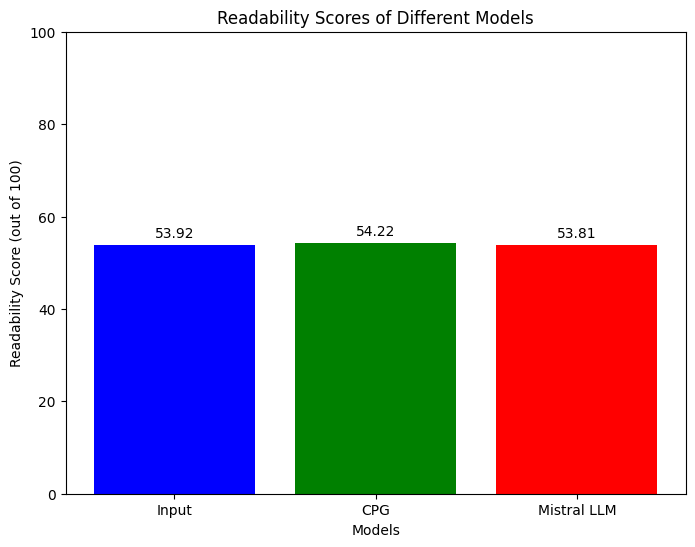

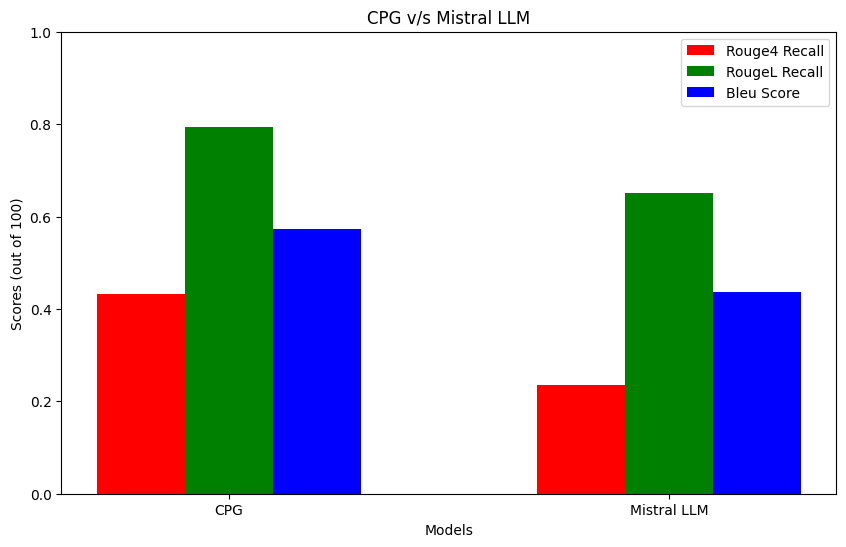

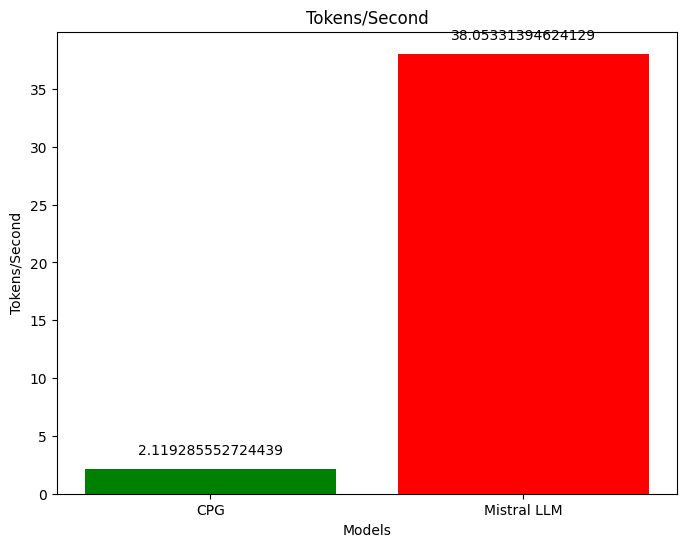

In [25]:
cpg_output, llm_output = compare_cpg_llm(context, api_key)

In [29]:
with open("./results/cpg_output.txt", "w") as outfile:
    outfile.write(cpg_output)

with open("./results/llm_output.txt", "w") as outfile:
    outfile.write(llm_output)